<h1>ASSIGNMENT 4 : Naive Bayes on Amazon Fine Food Reviews</h1>

Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews

<strong> OBJECTIVES :</strong>
    - Featurization/ Vectorization : Bow, tf-idf, avg w2v, tf-idf w2v
    - Train & Test Split : Time based slicing (60:20:20)
    - Cross validation : Simpe cv to find optimal alpha for each Vectorization
    - Test accuracy,f1 score,precsion,confusion matrix applied on all vectorization
    - Naive Bayes model : MultinomialNB

In [2]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
import pickle
def savetofile(obj,filename):
    pickle.dump(obj,open(filename+".p","wb"))
def openfromfile(filename):
    temp = pickle.load(open(filename+".p","rb"))
    return temp

In [4]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score

In [5]:
# Loading Pre-Processed data( Reviews ) from database
conn = sqlite3.connect('final_database.sqlite')
data = pd.read_sql_query('''SELECT * FROM Reviews''',conn)

In [6]:
data.head(3)

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanText
0,138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,positive,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,witti littl book make son laugh loud recit car...
1,138688,150506,0006641040,A2IW4PEEKO2R0U,Tracy,1,1,positive,1194739200,"Love the book, miss the hard cover version","I grew up reading these Sendak books, and watc...",grew read sendak book watch realli rosi movi i...
2,138689,150507,0006641040,A1S4A3IQ2MU7V4,"sally sue ""sally sue""",1,1,positive,1191456000,chicken soup with rice months,This is a fun way for children to learn their ...,fun way children learn month year learn poem t...


In [7]:
data.shape

(364171, 12)

In [8]:
# Sorting data in ascending order wrt time
data["Time"] = pd.to_datetime(data["Time"], unit = "s")
data = data.sort_values(by = "Time")

In [9]:
data.head(3)

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanText
0,138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,positive,1999-10-08,EVERY book is educational,this witty little book makes my son laugh at l...,witti littl book make son laugh loud recit car...
30,138683,150501,0006641040,AJ46FKXOVC7NR,Nicholas A Mesiano,2,2,positive,1999-10-25,This whole series is great way to spend time w...,I can remember seeing the show when it aired o...,rememb see show air televis year ago child sis...
424,417839,451856,B00004CXX9,AIUWLEQ1ADEG5,Elizabeth Medina,0,0,positive,1999-12-02,Entertainingl Funny!,Beetlejuice is a well written movie ..... ever...,beetlejuic well written movi everyth excel act...


In [10]:
data["Score"].value_counts()

positive    307061
negetive     57110
Name: Score, dtype: int64

In [84]:
X = data["CleanText"]
y = data["Score"]

In [85]:
#Splitting sampe data in train and test dataset in  60:20:20
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import train_test_split


X_1, X_test, y_1, y_test = train_test_split(X, y, test_size=0.2, shuffle = False)

# split the train data set into cross validation train and cross validation test
X_train, X_cv, y_train, y_cv = train_test_split(X_1, y_1, test_size=0.2,random_state = 0)
print(X_train.shape, X_test.shape, X_cv.shape)

(233068,) (72835,) (58268,)


In [45]:
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import f1_score

def Simple_cv(X_tr,y_tr,Xcv,ycv,NB_type):
    cl = ('positive','negetive')
    cv_scores = []
    myList = [0.00001, 0.0001, 0.001, 0.01, 1, 10, 100]
    #pack = list(filter(lambda x: x % 2 != 0, myList))
    
    for a in myList:
        if(NB_type==1):
            NB = BernoulliNB(alpha=a)

            # fitting the model on crossvalidation train
            NB.partial_fit(X_tr, y_tr,classes=cl)

            # predict the response on the crossvalidation train
            pred = NB.predict(Xcv)

            # evaluate CV f1 score
            f1s = f1_score(ycv, pred, average='weighted') 
            cv_scores.append(f1s)
        else :
            NB = MultinomialNB(alpha=a)

            # fitting the model on crossvalidation train
            NB.partial_fit(X_tr, y_tr,classes=cl)

            # predict the response on the crossvalidation train
            pred = NB.predict(Xcv)

            # evaluate CV f1 score
            f1s = f1_score(ycv, pred, average='weighted') 
            cv_scores.append(f1s)
    MSE = [1 - x for x in cv_scores]
    optimal_a = myList[MSE.index(min(MSE))]
    print('\nThe optimal alpha is %f.' % optimal_a)

    # plot misclassification error vs a 
    plt.plot(myList, MSE)

    for xy in zip(myList, np.round(MSE,3)):
        plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')

    plt.xlabel('Number of alpha')
    plt.ylabel('Misclassification Error')
    plt.show()

    print("the misclassification error for each alpha value is : ", np.round(MSE,5))
    
    return optimal_a

In [86]:
# function to define different performance measures
from wordcloud import WordCloud, STOPWORDS 

def metric(X_tr,y_tr,Xt,yt,NB_type,vectorizer):
    if(NB_type==1):
        NB = BernoulliNB(alpha=a)
        NB.fit(X_tr,y_tr)
        pred = NB.predict(Xt)
    else :
        NB = MultinomialNB(alpha=a)
        NB.fit(X_tr,y_tr)
        pred = NB.predict(Xt)
        
    acc = accuracy_score(yt, pred, normalize=True) * float(100)
    print('\n****Test accuracy for a = %f is %d%%' % (a,acc))
    
    cm = confusion_matrix(yt, pred)
    print("\nConfusion Matrix :")
    print(cm)
    
    plt.figure()
    heatmap = sns.heatmap(cm, annot=True, fmt="d")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right')
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.title("CONFUSION MATRIX ")
    
    f1s = f1_score(yt, pred, average='weighted')
    print("\nf1 score is "+str(f1s))
    
    prs = precision_score(yt, pred, average='weighted')
    print("\nprecision score is "+str(prs))
    
    rcs = recall_score(yt, pred, average='weighted')
    print("\nrecall score is "+str(rcs))
    
    
   
    neg_class_prob_sorted = NB.feature_log_prob_[0, :].argsort()[ : : -1]
    pos_class_prob_sorted = NB.feature_log_prob_[1, :].argsort()[ : : -1]

    print("\nTOP Negetive words :\n")
    po = np.take(vectorizer.get_feature_names(), neg_class_prob_sorted[:100])
    print(po)
    print("\nTOP positive words\n")
    ne = np.take(vectorizer.get_feature_names(), pos_class_prob_sorted[:100])
    print(ne)
    
    positive_words = ' '
    for words in po: 
        positive_words = positive_words + words + ' '
    
    wordcloud_p = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                min_font_size = 10).generate(positive_words) 
    # plot the WordCloud image                        
    plt.figure(figsize = (4, 4), facecolor = None) 
    plt.imshow(wordcloud_p) 
    plt.axis("off") 
    plt.tight_layout(pad = 0) 
    plt.title('TOP POSITIVE WORDS')
    
    print("\n\n")
    
    negetive_words = ' '
    for words in ne: 
        negetive_words = negetive_words + words + ' '
    
    wordcloud_n = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                min_font_size = 10).generate(negetive_words) 
  
    # plot the WordCloud image                        
    plt.figure(figsize = (4, 4), facecolor = None) 
    plt.imshow(wordcloud_n) 
    plt.axis("off") 
    plt.tight_layout(pad = 0) 
    plt.title('TOP NEGETIVE WORDS')
  
    plt.show() 

<h3> BoW </h3>

In [48]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
from sklearn.feature_extraction.text import CountVectorizer

In [49]:
count_vect = CountVectorizer()
X_train = count_vect.fit_transform(X_train)
X_cv = count_vect.transform(X_cv)
X_test = count_vect.transform(X_test)

In [50]:
print("the type of count vectorizer ",type(X_train))
print("the shape of out text BOW vectorizer ",X_train.get_shape())
print("the number of unique words ", X_train.get_shape()[1])

print("the shape of out text BOW vectorizer ",X_cv.get_shape())
print("the number of unique words ", X_cv.get_shape()[1])

print("the shape of out text BOW vectorizer ",X_test.get_shape())
print("the number of unique words ", X_test.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (233068, 132126)
the number of unique words  132126
the shape of out text BOW vectorizer  (58268, 132126)
the number of unique words  132126
the shape of out text BOW vectorizer  (72835, 132126)
the number of unique words  132126



The optimal alpha is 1.000000.


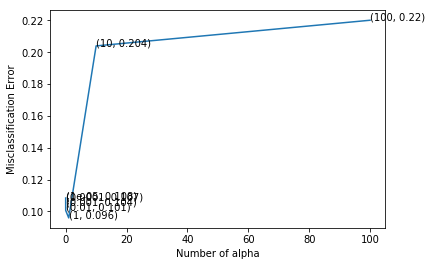

the misclassification error for each alpha value is :  [0.10844 0.10671 0.10433 0.10062 0.09593 0.20399 0.22012]


In [51]:
# predicting optimal alpha using simple cross validation using MultinomialNB
a = Simple_cv(X_train,y_train,X_cv,y_cv,0)


****Test accuracy for a = 1.000000 is 89%

Confusion Matrix :
[[ 7609  4922]
 [ 2480 57824]]

f1 score is 0.893895758972124

precision score is 0.8927615136243392

recall score is 0.8983730349419922

TOP Negetive words :

['tast' 'like' 'product' 'one' 'flavor' 'would' 'tri' 'use' 'good' 'coffe'
 'buy' 'get' 'order' 'food' 'tea' 'dont' 'even' 'box' 'make' 'amazon'
 'much' 'eat' 'bag' 'realli' 'time' 'look' 'love' 'packag' 'purchas'
 'review' 'bought' 'dog' 'first' 'chocol' 'disappoint' 'want' 'bad'
 'better' 'also' 'price' 'think' 'drink' 'could' 'know' 'made' 'say'
 'water' 'didnt' 'ingredi' 'give' 'sugar' 'got' 'great' 'brand' 'thought'
 'well' 'way' 'ive' 'littl' 'two' 'smell' 'someth' 'receiv' 'find' 'never'
 'pack' 'store' 'thing' 'mix' 'item' 'cup' 'open' 'differ' 'money' 'still'
 'back' 'day' 'sweet' 'contain' 'cat' 'year' 'howev' 'stuff' 'compani'
 'ship' 'found' 'recommend' 'sinc' 'cant' 'doesnt' 'seem' 'away' 'old'
 'see' 'work' 'bar' 'actual' 'sure' 'bottl' 'come']

TOP pos

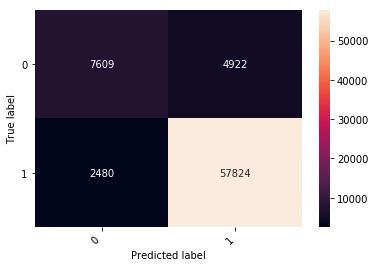

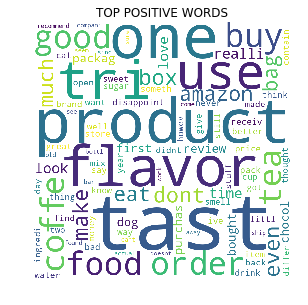

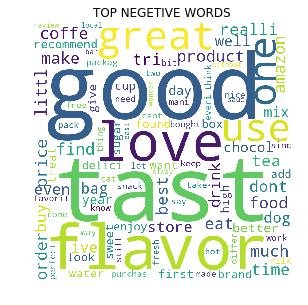

In [83]:
#performance measures on MultinomialNB
metric(X_train,y_train,X_test,y_test,0,count_vect)

<strong>Observation :</strong>
-The optimal alpha value for BoW using MultinomialNB is 1 

<h3>TF-IDF</h3>

In [87]:
from sklearn.feature_extraction.text import TfidfVectorizer

tf_idf_vect = TfidfVectorizer()
X_train = tf_idf_vect.fit_transform(X_train)
X_cv = tf_idf_vect.transform(X_cv)
X_test = tf_idf_vect.transform(X_test)


The optimal alpha is 0.010000.


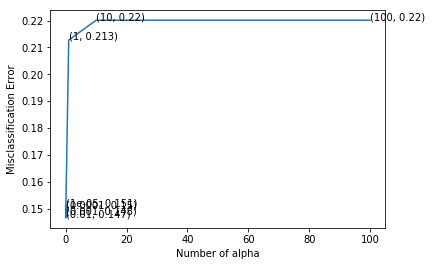

the misclassification error for each alpha value is :  [0.15084 0.15021 0.14824 0.14655 0.21273 0.2201  0.2201 ]


In [88]:
# predicting optimal alpha using simple cross validation using MultinomialNB
a = Simple_cv(X_train,y_train,X_cv,y_cv,0)


****Test accuracy for a = 0.010000 is 86%

Confusion Matrix :
[[ 3244  9287]
 [  572 59732]]

f1 score is 0.8331180708085083

precision score is 0.8628039966000244

recall score is 0.8646392531063363

TOP Negetive words :

['tast' 'like' 'product' 'would' 'flavor' 'coffe' 'one' 'tri' 'buy'
 'order' 'box' 'tea' 'disappoint' 'good' 'dont' 'get' 'use' 'even' 'food'
 'bag' 'bad' 'purchas' 'much' 'bought' 'amazon' 'eat' 'look' 'packag'
 'realli' 'chocol' 'review' 'dog' 'money' 'didnt' 'time' 'receiv'
 'thought' 'price' 'make' 'item' 'smell' 'want' 'better' 'could' 'think'
 'got' 'first' 'drink' 'know' 'love' 'made' 'say' 'water' 'wast' 'never'
 'return' 'pack' 'way' 'ingredi' 'someth' 'brand' 'open' 'sugar' 'give'
 'away' 'cup' 'two' 'also' 'store' 'ship' 'ive' 'expect' 'thing' 'back'
 'howev' 'compani' 'stuff' 'mix' 'old' 'differ' 'littl' 'bar' 'hope'
 'wont' 'sweet' 'still' 'well' 'contain' 'cat' 'cant' 'doesnt' 'dri'
 'hard' 'bottl' 'find' 'cooki' 'noth' 'mayb' 'sure' 'read']

TOP posit

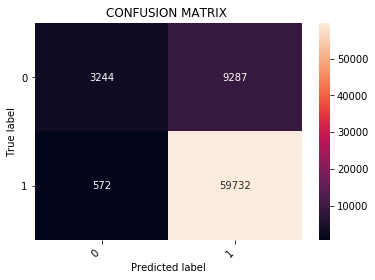

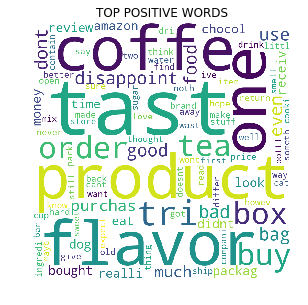

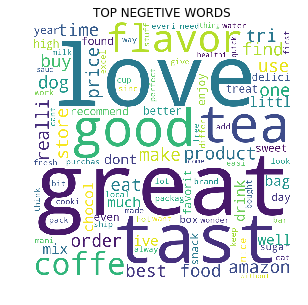

In [89]:
#performance measures on MultinomialNB
metric(X_train,y_train,X_test,y_test,0,tf_idf_vect)

<strong>Observation :</strong>
-The optimal alpha value for TF-IDF using MultinomialNB is 0.0100

<h3>Conclusion</h3>
    -Here we have considered whole Amazon food reviews Data set ( i.e. 364171 data points)
    <br>-Comparing MultinomialNB with BoW and TF-IDF: BoW has performed better than TF-IDF</br>
    <br>-Naive Bayes algorithm is very much faster than KNN.</br>